# Homework 4: Clustering

## Setup

###  Step 1: Load the 20 Newsgroups Data

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. You can find additional information here:

In [29]:
from sklearn.datasets import fetch_20newsgroups

# You can load just a subset of categories for simplicity
categories = ['talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc']

# Load the training data
newsgroups_train = fetch_20newsgroups(subset="train", categories=categories)


In [30]:
# Example of accessing the data
print(newsgroups_train.data[0])
print(newsgroups_train.target[0])  # Corresponding target to the above document

# The size of the dataset can be found by checking the length of the data list
print(f"Training set size: {len(newsgroups_train.data)}")

From: golchowy@alchemy.chem.utoronto.ca (Gerald Olchowy)
Subject: Re: Help fight the Clinton Administration's invasion of your privacy
Organization: University of Toronto Chemistry Department
Lines: 16

In article <9308@blue.cis.pitt.edu> cjp+@pitt.edu (Casimir J Palowitch) writes:
>The Clinton Administration wants to "manage" your use of digital
>encryption. This includes a proposal which would limit your use of
>encryption to a standard developed by the NSA, the technical details of 
>which would remain classified with the government.
>
>This cannot be allowed to happen.
>

It is a bit unfair to call blame the Clinton Administration alone...this
initiative was underway under the Bush Administration...it is basically
a bipartisan effort of the establishment Demopublicans and
Republicrats...the same bipartisan effort that brought the S&L scandal,
and BCCI, etc.

Gerald

2
Training set size: 1575


### Step 2:  Vectorize our data

We need to turn our text into sets of words.  However, we don't want words that are either too frequent or infrequent.  To do this, we'll use the TF-IDF vectorizer, and pick the top N (up to you!) words.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Sample data
documents = newsgroups_train.data

# Initialize the TFIDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Fit the model and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

print(vectorizer)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each feature
# Here, we sum the scores for each term across all documents
sums = tfidf_matrix.sum(axis=0)

# Connecting term to its sums score
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0,col]))

# Create a DataFrame with the terms and their scores
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking = ranking.sort_values('rank', ascending=False)

# Select top N terms
top_n = 1000
top_n_terms = ranking.head(top_n)
print(top_n_terms)

TfidfVectorizer(stop_words='english')
          term       rank
11420      edu  61.208854
8452       com  47.374596
22292   people  33.571833
31314   writes  29.042544
5205   article  28.036692
...        ...        ...
14000    glock   2.835863
11137     dseg   2.833897
22108   passes   2.833331
11790      eng   2.830592
8872   consent   2.827678

[1000 rows x 2 columns]


In [32]:
top_n_terms = top_n_terms.iloc[2:]
print(top_n_terms)

          term       rank
22292   people  33.571833
31314   writes  29.042544
5205   article  28.036692
16748   israel  27.562426
14432      gun  25.451788
...        ...        ...
14000    glock   2.835863
11137     dseg   2.833897
22108   passes   2.833331
11790      eng   2.830592
8872   consent   2.827678

[998 rows x 2 columns]


### Step 3: Join your terms with the Glove Vectors

GloVe vectors are word embeddings produced by the GloVe model, developed at Stanford. You can find them in the [Stanford GloVe repository](https://nlp.stanford.edu/projects/glove/). You'll probably want the smallest one (glove.6B). Once you have the embeddings, you’ll need to map these vectors to your data — keep in mind that the vectors come in different dimensions. I’ll use the 100-dimensional vectors for demonstration purposes.

In [ ]:
# this code block is useful if you are working in a remote environment, such as Colab
# note that the download may take a while
# ! wget https://nlp.stanford.edu/data/glove.6B.zip
# ! unzip glove.6B.zip

In [16]:
import requests
import zipfile
import os

url = 'https://nlp.stanford.edu/data/glove.6B.zip'
zip_filename = 'glove.6B.zip'

# Download the file
print(f"Downloading {zip_filename}...")
response = requests.get(url, stream=True)
response.raise_for_status()

with open(zip_filename, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
print("Download complete.")

# Extract the zip file
print("Extracting files...")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('.')
print("Extraction complete.")

# Clean up the downloaded zip file
os.remove(zip_filename)
print("Cleaned up zip file.")


Download complete.
Extracting files...
Extraction complete.
Cleaned up zip file.


In [23]:
import numpy as np

# Load GloVe vectors into a dictionary:
glove_vectors = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_vectors[word] = vector

In [33]:
original_feature_names = top_n_terms.term

# Note that not all features are present in the glove vectors, so we'll filter here:
word_vectors = []
filtered_feature_names = []

for word in original_feature_names:
    if word in glove_vectors:
        word_vectors.append(glove_vectors[word])
        filtered_feature_names.append(word)

# Convert the list of vectors to a numpy array
word_vectors = np.array(word_vectors)

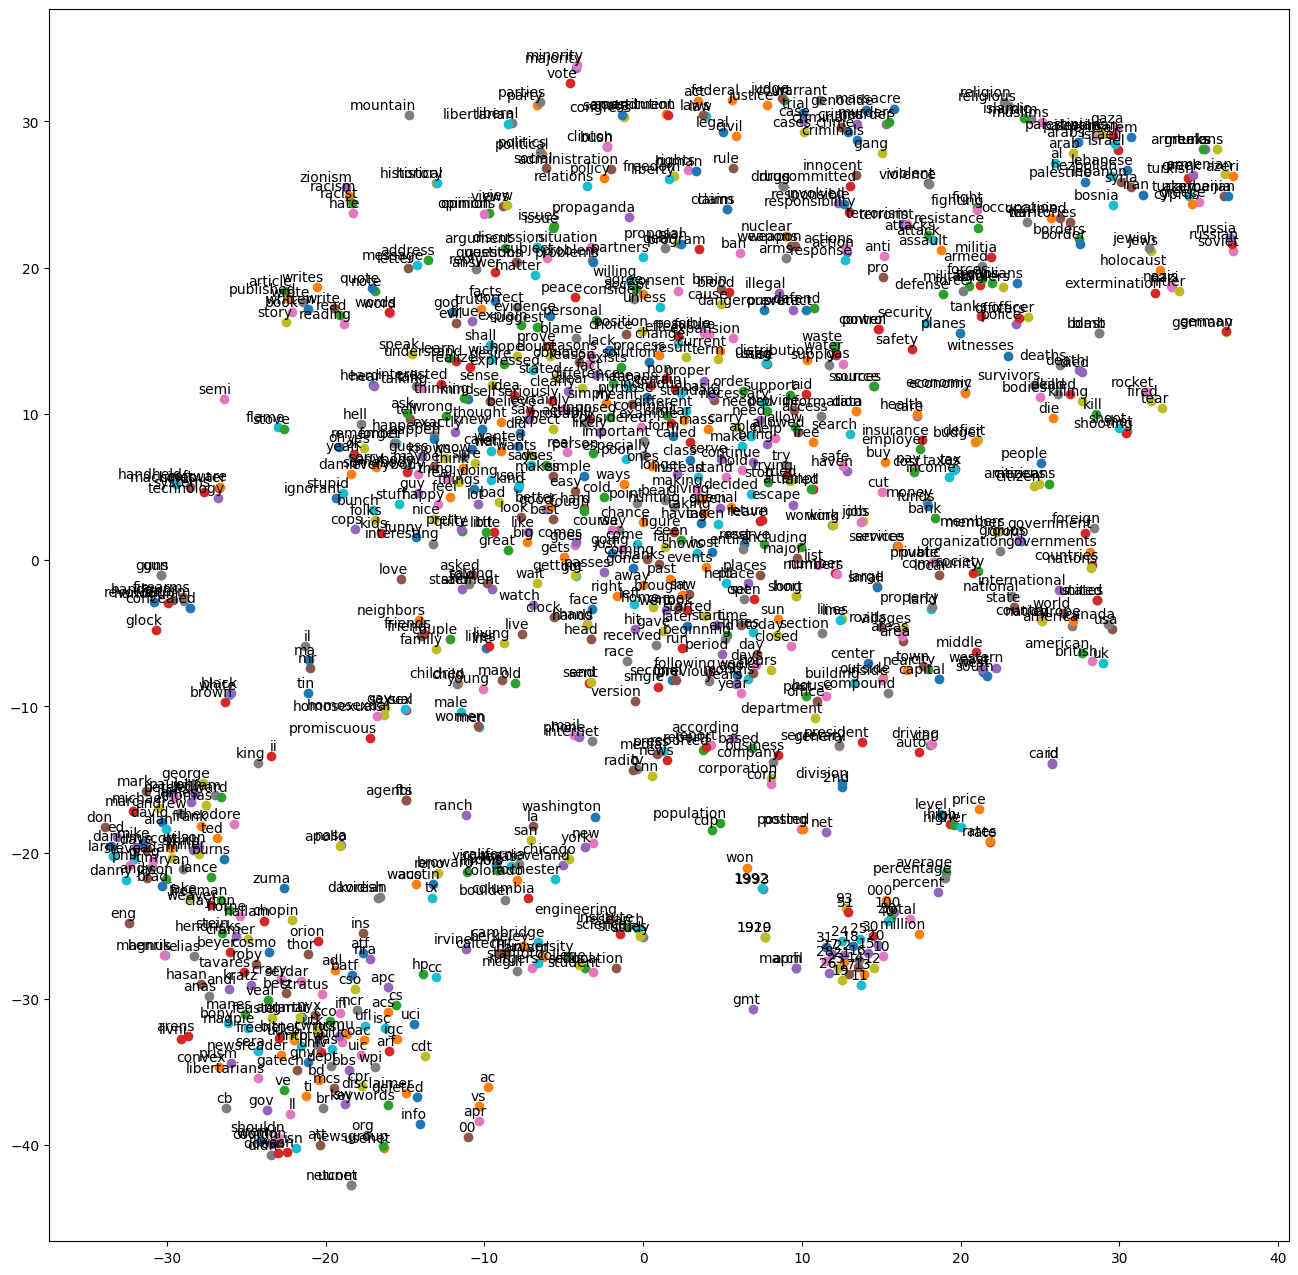

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to project the vectors into a 2D space
tsne = TSNE(n_components=2)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the projection
plt.figure(figsize=(16, 16))
for i, word in enumerate(filtered_feature_names):
    if word in glove_vectors:  # Only plot words that were in the GloVe vectors
        plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
plt.show()

### Analysis of 1997 Political climate 
###### "We were so young"

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering


#### We begin this exercise by scaling our data and applying 3 dimenionailty reduction methods PCA, TSNE and UMAP

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(word_vectors)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, perplexity=30, max_iter= 300, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)


c:\Users\Black Knight\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### We then fitted the data to 3 clustering methods: Kmeans, HAC and DBScan. We applied all three methods to each data that were reduced including data that was only scaled for comparison

In [45]:
k = 3
kmeans = KMeans(n_clusters=k, n_init= 'auto', random_state=42)
kmeans_pca = kmeans.fit_predict(X_pca)
kmeans_tsne = kmeans.fit_predict(X_tsne)
kmeans_umap = kmeans.fit_predict(X_umap)
kmeans_unreduc = kmeans.fit_predict(X_scaled)

hac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hac_pca = hac.fit_predict(X_pca)
hac_tsne = hac.fit_predict(X_tsne)
hac_umap = hac.fit_predict(X_umap)
hac_unreduc = hac.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_pca = dbscan.fit_predict(X_pca)
dbscan_tsne = dbscan.fit_predict(X_tsne)
dbscan_umap = dbscan.fit_predict(X_umap)
dbscan_unreduc = dbscan.fit_predict(X_scaled)



#### Once the data was fitted to each model we used the Davies-Bouldin Index since it assesses the quality of clusters by comparing the ratio of the within cluster scatter to the between cluster separation for all cluster pairs. We noted that lower scores indicate better clustering where clusters are more distinct and compact

In [71]:
from sklearn.metrics import davies_bouldin_score

dbi_kmeans_pca = davies_bouldin_score(X_pca, kmeans_pca)
dbi_kmeans_tsne = davies_bouldin_score(X_tsne, kmeans_tsne)
dbi_kmeans_umap = davies_bouldin_score(X_umap, kmeans_umap)
dbi_kmeans_unreduc = davies_bouldin_score(X_scaled, kmeans_unreduc)

dbi_hac_pca = davies_bouldin_score(X_pca, hac_pca)
dbi_hac_tsne = davies_bouldin_score(X_tsne, hac_tsne)
dbi_hac_umap = davies_bouldin_score(X_umap, hac_umap)
dbi_hac_unreduc = davies_bouldin_score(X_scaled, hac_unreduc)

In [72]:
valid_mask = dbscan_unreduc != -1
if np.sum(valid_mask) > 0 and len(np.unique(dbscan_unreduc[valid_mask])) > 1:
    dbi_dbscan_unreduc = davies_bouldin_score(X_scaled[valid_mask], dbscan_unreduc[valid_mask])
else:
    dbi_dbscan_unreduc = np.nan # Not enough clusters to compute a score

valid_mask = dbscan_pca != -1
if np.sum(valid_mask) > 0 and len(np.unique(dbscan_pca[valid_mask])) > 1:
    dbi_dbscan_pca = davies_bouldin_score(X_pca[valid_mask], dbscan_pca[valid_mask])
else:
    dbi_dbscan_pca = np.nan

valid_mask = dbscan_tsne != -1
if np.sum(valid_mask) > 0 and len(np.unique(dbscan_tsne[valid_mask])) > 1:
    dbi_dbscan_tsne = davies_bouldin_score(X_tsne[valid_mask], dbscan_tsne[valid_mask])
else:
    dbi_dbscan_tsne = np.nan

valid_mask = dbscan_umap != -1
if np.sum(valid_mask) > 0 and len(np.unique(dbscan_umap[valid_mask])) > 1:
    dbi_dbscan_umap = davies_bouldin_score(X_umap[valid_mask], dbscan_umap[valid_mask])
else:
    dbi_dbscan_umap = np.nan

In [74]:
print("Davies-Bouldin Index Scores:")
print("-" * 30)
print(f"K-Means (No Reduction): {dbi_kmeans_unreduc:.3f}")
print(f"K-Means (PCA):      {dbi_kmeans_pca:.3f}")
print(f"K-Means (t-SNE):    {dbi_kmeans_tsne:.3f}")
print(f"K-Means (UMAP):     {dbi_kmeans_umap:.3f}")
print("-" * 30)
print(f"HAC (No Reduction):     {dbi_hac_unreduc:.3f}")
print(f"HAC (PCA):          {dbi_hac_pca:.3f}")
print(f"HAC (t-SNE):        {dbi_hac_tsne:.3f}")
print(f"HAC (UMAP):         {dbi_hac_umap:.3f}")
print("-" * 30)
print(f"DBSCAN (No Reduction):  {dbi_dbscan_unreduc:.3f}")
print(f"DBSCAN (PCA):       {dbi_dbscan_pca:.3f}")
print(f"DBSCAN (t-SNE):     {dbi_dbscan_tsne:.3f}")
print(f"DBSCAN (UMAP):      {dbi_dbscan_umap:.3f}")

Davies-Bouldin Index Scores:
------------------------------
K-Means (No Reduction): 3.772
K-Means (PCA):      0.792
K-Means (t-SNE):    0.853
K-Means (UMAP):     0.980
------------------------------
HAC (No Reduction):     3.851
HAC (PCA):          0.812
HAC (t-SNE):        0.873
HAC (UMAP):         0.438
------------------------------
DBSCAN (No Reduction):  nan
DBSCAN (PCA):       0.656
DBSCAN (t-SNE):     0.248
DBSCAN (UMAP):      0.796


#### From the index scores we see that data reduced with UMAP and fitted to the HAC cluster algorithm performed the best. Somewhat surprisinnly was the dreadful performance of the un reduced data. Given this we decided to map this combination to the dendrogram

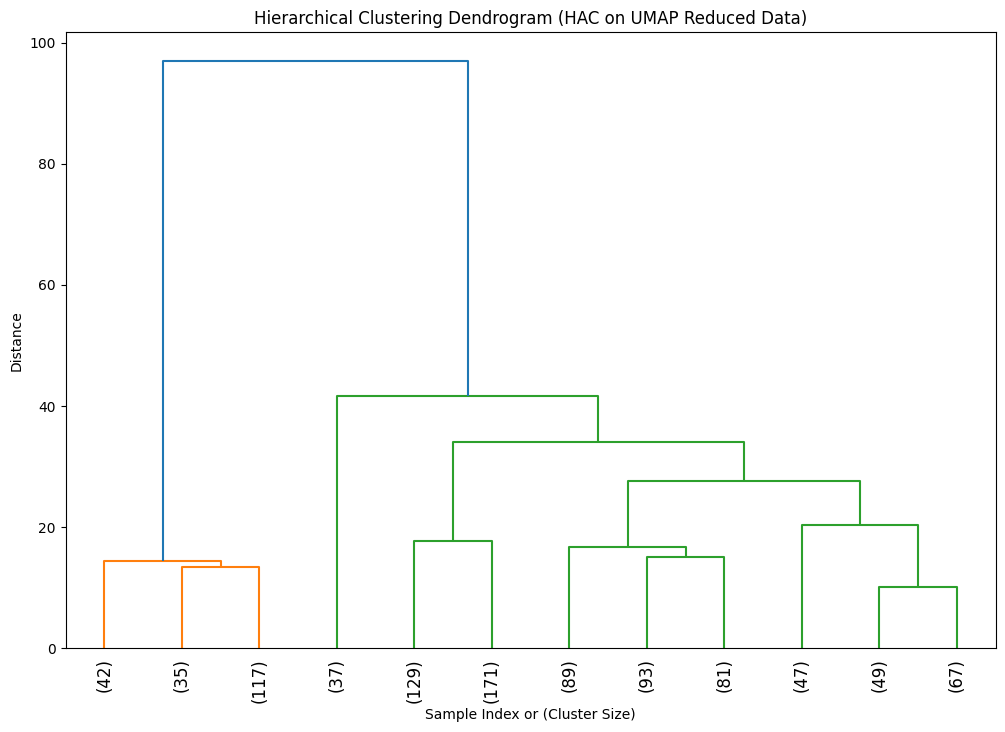

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import load_iris

Z = linkage(X_umap, method='ward')

plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram (HAC on UMAP Reduced Data)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12,  
    show_leaf_counts=True,  
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.show()



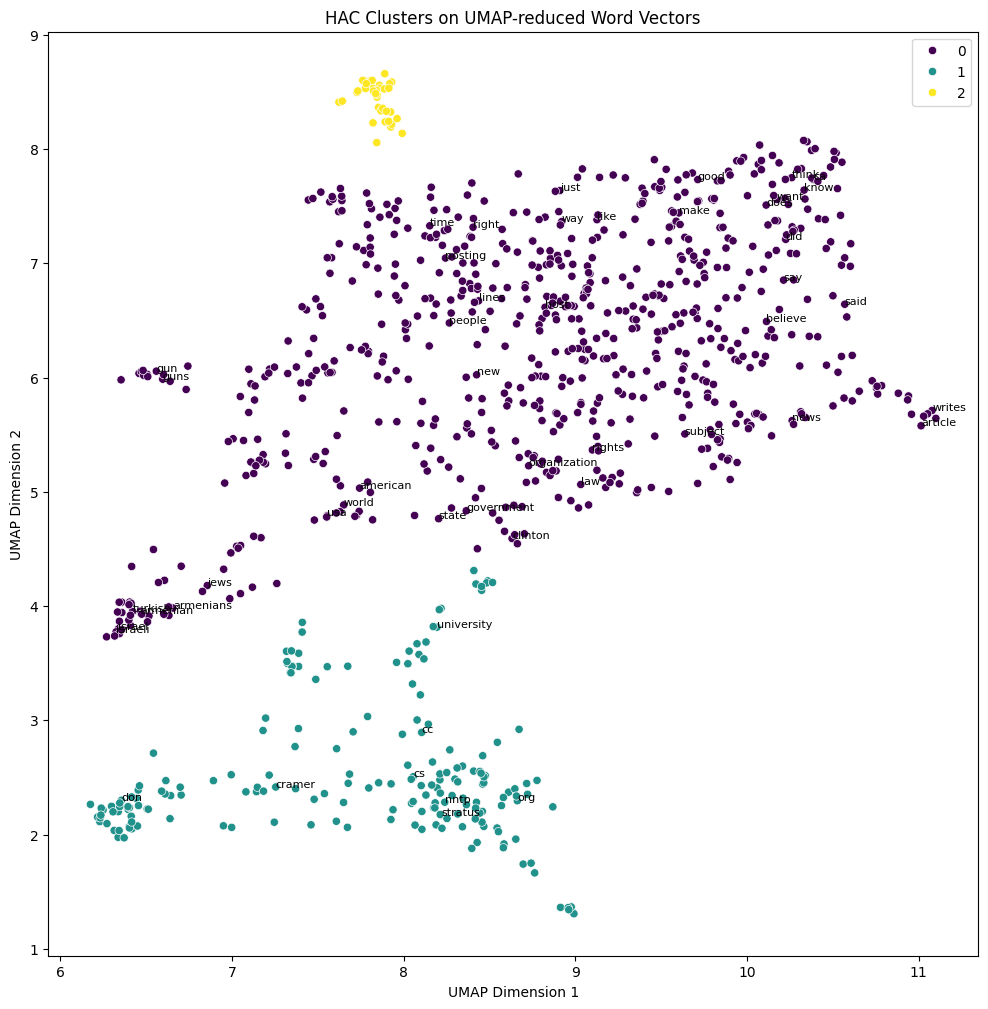

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=hac_umap, palette='viridis', legend='full')

for i, word in enumerate(filtered_feature_names):
    if i < 50:  
        plt.annotate(word, (X_umap[i, 0], X_umap[i, 1]), fontsize=8)

plt.title('HAC Clusters on UMAP-reduced Word Vectors')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


#### 1. Im not sure anything happens if you project the data first. I guess I would usually prefer to project in order to see what inital k ill use but since I knew that these were 3 datasets I used k=3

#### 2. The cluster boundaries werent strong enough and my accuracy wasnt very high so it is difficult to say what was the major clusterings for each subset.

#### 3. This political data was probably a bad choice for my first time using these models since there arent that many distingushing features/ words. I would have assumed that the middle east data set would have been distinct and would have cluster around Israel or Iraq. However it seems to have been add to the largest cluster that seems to encompass evrything. Since political discussion is so similar this does seem to make sence. Also arguments about the topics du jour in 1997 may have followed a more measured template that is difficult to distinguish so it may be interesting to compare this to articles from today.